In [1]:
import xarray as xr

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats




# font size for plots
SMALL_SIZE = 8
BIGGER_SIZE = 12
plt.rc('font', size=  BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rcParams["font.family"] = "serif"

#

#=================================================================================

#speed
ylabel = "Translation Speed"
ymin = 0.
ymax = 50.
#=================================================================================
mon = '_JASO_'


#------------------------------------------------------------
var = 'tang'
ymin = -80.
ymax =  80.
ylabel = "Tangential Acceleration"


var = 'curv'
ymin =   0.
ymax =  80.
ylabel = "Curvature Acceleration"

#------------------------------------------------------------



dom = '0_90'
titleString1 = '(a) Entire Atlantic [July-October]'
titleString2 = '(c) Entire Atlantic [July-October]'

dom = '25_45'
titleString1 = '(b) Atlantic: 25-45N [July-October]'
titleString2 = '(d) Atlantic: 25-45N [July-October]'

#------------------------------------------------------------




fileName = var+mon + "atl_"+dom+".nc"
output1 = "scatter_" + var+ mon + "atl_"+dom+".png"
output2 = "beta_" + var+ mon + "atl_"+dom+".png"
xlabelString = "Quantiles of Conditional " + ylabel




In [2]:
#open the data set
ds = xr.open_dataset(fileName)
print(ds)

<xarray.Dataset>
Dimensions:    (ncl0: 1, ncl1: 1, ncl2: 1, ncl3: 1, ncl5: 15892, ncl6: 15892, ncl7: 54, ncl8: 54, storm: 15892)
Dimensions without coordinates: ncl0, ncl1, ncl2, ncl3, ncl5, ncl6, ncl7, ncl8, storm
Data variables:
    startYear  (ncl0) int32 ...
    endYear    (ncl1) int32 ...
    latS       (ncl2) float32 ...
    latN       (ncl3) float32 ...
    Dates      (storm) datetime64[ns] ...
    Data       (ncl5) float64 ...
    Fracyear   (ncl6) float32 ...
    years      (ncl7) float32 ...
    yearly     (ncl8) float64 ...


In [3]:
# now lets read the yearly averaged data and establish some basic trend using OLS = this is the trend of the mean
#
yData  = ds.yearly
years  = ds.years
dfA = pd.DataFrame({'years':years, 'yData':yData, 'const':1})
reg1 = sm.OLS(endog=dfA['yData'], exog=dfA[['const', 'years']],missing='drop')
results = reg1.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  yData   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.416
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.126
Time:                        23:23:17   Log-Likelihood:                -144.59
No. Observations:                  54   AIC:                             293.2
Df Residuals:                      52   BIC:                             297.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.2427     62.418      1.862      0.0

In [4]:
Data  = ds.Data
Time  = ds.Fracyear


#print(Data.head())
#print(Time.head())

print(Data.values)
print(Time.values)

[22.24284351  9.11453446 14.34629095 ... 53.67033101 87.84647351
 34.74911025]
[1966.5442 1966.5446 1966.5449 ... 2019.8319 2019.8322 2019.8325]


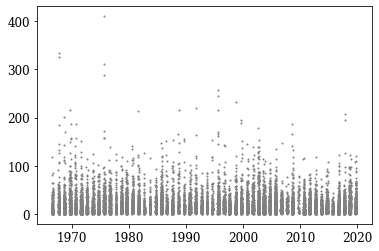

In [5]:
#plt.plot(years, accel, color='grey',markersize=1)
plt.plot(Time, Data,'o', color='grey',markersize=1)


In [6]:
# Linear regression using numpy
slope, intercept, r_value, p_value, std_err = stats.linregress(Time.values,Data.values)
print("R-squared : %f" % r_value**2)
print ("slope    : %f" % slope)
print ("p value  : %f" % p_value)
print ("intercept  : %f" % intercept)


R-squared : 0.001184
slope    : -0.045105
p value  : 0.000014
intercept  : 108.891073


In [7]:
df = pd.DataFrame({'Time':Time, 'Data':Data})
#print(df)

In [8]:
# A frst order polynomial fit to get the linear regression
poly = smf.ols(formula='Data ~ 1 +  Time', data=df).fit()
print (poly.summary())


                            OLS Regression Results                            
Dep. Variable:                   Data   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.84
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.43e-05
Time:                        23:23:17   Log-Likelihood:                -71042.
No. Observations:               15892   AIC:                         1.421e+05
Df Residuals:                   15890   BIC:                         1.421e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    108.8911     20.721      5.255      0.0

In [9]:

mod = smf.quantreg('Data ~ Time', df)


result = mod.fit(q=.5)
print(result.summary())
#print (dir(res))

print(result.pvalues['Time'])
print(result.params['Time'])

                         QuantReg Regression Results                          
Dep. Variable:                   Data   Pseudo R-squared:            2.238e-06
Model:                       QuantReg   Bandwidth:                       2.635
Method:                 Least Squares   Sparsity:                        33.53
Date:                Tue, 24 Nov 2020   No. Observations:                15892
Time:                        23:23:17   Df Residuals:                    15890
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9368     16.426      1.031      0.303     -15.260      49.133
Time          -0.0020      0.008     -0.243      0.808      -0.018       0.014

The condition number is large, 2.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


In [10]:
quantiles = [0.05,.10,.15,.2,.3,.5,.7,.8,.85,.9,.95]
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
   
    
    
models = [fit_model(x1) for x1 in quantiles]
#models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])
models = pd.DataFrame(models, columns=['q', 'b', 'p', 'lb', 'ub'])




/home/anant/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [11]:
#quantiles = np.arange(.05,.96, .05)

quantiles = [0.05,.10,.15,.2,.3,.5,.7,.8,.85,.9,.95]
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'],res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
   
        
models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])

print(models.round(4))


/home/anant/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


       q         a       b       p      lb      ub
0   0.05  -17.5327  0.0096  0.0018  0.0035  0.0156
1   0.10  -11.8884  0.0073  0.0386  0.0004  0.0142
2   0.15   -9.9264  0.0069  0.0935 -0.0012  0.0149
3   0.20  -12.8951  0.0089  0.0557 -0.0002  0.0180
4   0.30  -16.3869  0.0118  0.0350  0.0008  0.0228
5   0.50   16.9368 -0.0020  0.8079 -0.0181  0.0141
6   0.70   89.8672 -0.0343  0.0042 -0.0578 -0.0108
7   0.80  163.0413 -0.0677  0.0000 -0.1004 -0.0350
8   0.85  216.4634 -0.0918  0.0000 -0.1336 -0.0500
9   0.90  254.9265 -0.1073  0.0001 -0.1611 -0.0536
10  0.95  459.7468 -0.2020  0.0001 -0.2998 -0.1043


In [12]:
np.savetxt(r'np.txt', models[["q","b","p","lb","ub"]], fmt='%1.2f & %1.3f & %1.3f &  [ %1.3f, %1.3f ] \\')


In [13]:
# Least square estimate of the trend of the mean

ols = smf.ols(formula='Data ~ Time', data=df).fit()
ols_ci = ols.conf_int().loc['Time'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Time'],
           lb = ols_ci[0],
           ub = ols_ci[1],
           p=ols.pvalues['Time'])
print(ols)


{'a': 108.89107227105401, 'b': -0.045104809927968836, 'lb': -0.06547322189876482, 'ub': -0.024736397957172845, 'p': 1.4299135607141035e-05}


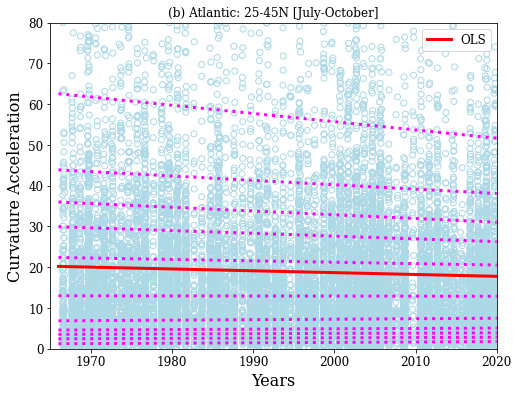

In [14]:
#x = np.arange(df.years.min(), df.years.max(), 50)

x = np.arange(1966,2021,1)

get_y = lambda a, b: a + b * x

n = 9
colors = pl.cm.jet(np.linspace(0,1,n))

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', linewidth=3, color='magenta')    
    
y = get_y(ols['a'], ols['b'])



ecolor = "lightblue"
ax.scatter(df.Time, df.Data, facecolors='none', edgecolors=ecolor) #, s=2 ,alpha=.7)
ax.plot(x, y, color='red', linewidth=3, label='OLS')
ax.set_xlim((1965,2020))
ax.set_ylim((ymin,ymax))
legend = ax.legend()
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel(ylabel, fontsize=16);
plt.title(titleString1)

plt.savefig(output1)


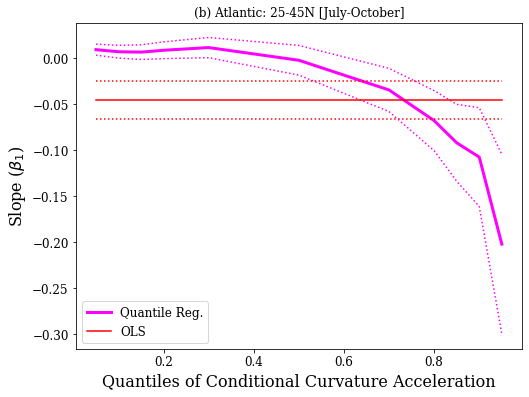

In [15]:
n = models.shape[0]
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(models.q, models.b,     color='magenta', linewidth=3, label='Quantile Reg.')
ax.plot(models.q, models.ub, linestyle='dotted', color='magenta')
ax.plot(models.q, models.lb, linestyle='dotted', color='magenta')

ax.plot(models.q, [ols['b']] * n, color='red', label='OLS')
ax.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
ax.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
legend = ax.legend()
ax.set_xlabel(xlabelString, fontsize=16)
ax.set_ylabel('Slope (' + r'$\beta_1$' +')', fontsize=16);
plt.title(titleString1)

plt.savefig(output2)


In [16]:
inter = 367.7540
slope = -0.1639

ydat = inter + slope*2019
print (ydat)

36.83990000000006
